In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib

##### Тут робота з даними та код на найкращий результат
Найкращим виявився бустер Light gradient boosting machine.<br>
Але я придумав зробити 5 різних LGBM моделей з різними features (попередньо я ранив і вибирав найкращі) та після цього зробити ensembling з певними вагами аби зменшити rmse ще на кілька сотих <br>
##### RMSE score на кеглі для моделі з features 1: 2.98968 <br>
##### RMSE score на кеглі для моделі з features 2: 2.96784 <br>
##### RMSE score на кеглі для моделі з features 3: 3.00927 <br>
##### RMSE score на кеглі для моделі з features 4: 3.02241 <br>
##### RMSE score на кеглі для моделі з features 5: 2.99478 <br>
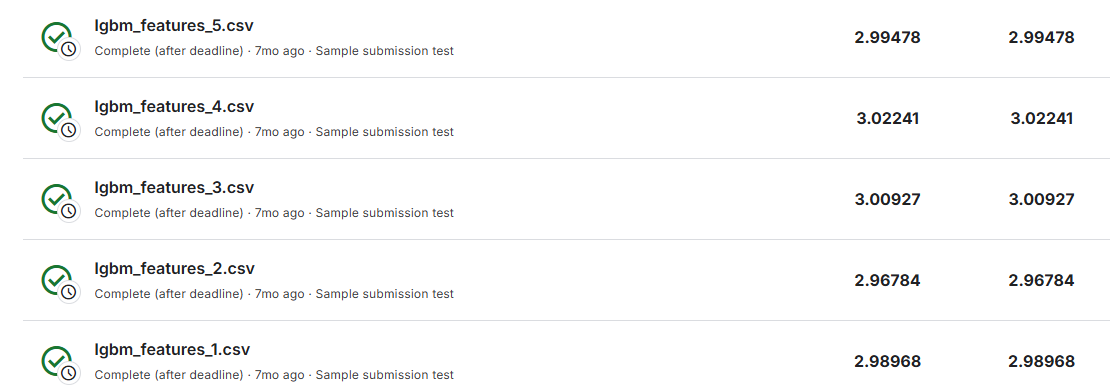
# Найкращий RMSE score на кеглі моделі ensemble: 2.94821 <br>
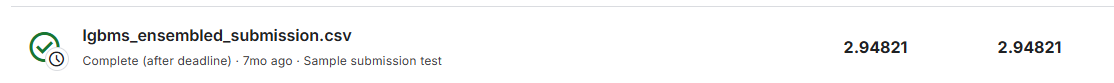

##### Посилання на мої кегл аккаунти https://www.kaggle.com/baredal (де найкращий результат) та https://www.kaggle.com/darebal (на цьому закінчився ліміт submissions на день) <br>
Дальше в коді буде видно, які features відповідають номерам та як була зробена фінальна модель <br>
Параметри моделі я також вибирав, ранячи і міняючи їх + дивився в інтернеті, які і як краще підібрати (можна було також використати GridSearchCV) <br>
Загалом проблема була в даних, я пододавав відстані різноманітні, розділив часові проміжки, також думав додати період дня як ніч та день, але з ним було гірше. Додав відстані до певних точок міста, де ціна явно буде різнитись <br>
Також, коли я буду писати категоричні дані, то я маю на увазі часові виміри та кількість пасажирів

In [ ]:
train = pd.read_csv('train_2M.csv',
                    parse_dates=["pickup_datetime"],
                    nrows=1e6)
test = pd.read_csv('test.csv')

In [ ]:
train = train.dropna()
train.shape


(999990, 7)

In [ ]:
def rmse(y_true, y_pred):
    mse = np.mean((y_pred - y_true) ** 2)
    return np.sqrt(mse)

Додавання часових проміжків (дати)

In [ ]:
def make_date(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")

    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['weekday'] = df['pickup_datetime'].dt.weekday
    df['year'] = df['pickup_datetime'].dt.year

    return df

train = make_date(train)
test = make_date(test)

Абсолютна відстань між початковою та кінцевою точкою посадки/висадки

In [ ]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()
    df['abs_diff_latitude'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()

add_travel_vector_features(train)
add_travel_vector_features(test)

Відстань між початковою та кінцевою точкою посадки/висадки

In [ ]:
def calculate_haversine(df):
    df['dlat'] = np.radians(df['dropoff_latitude'] - df['pickup_latitude'])
    df['dlon'] = np.radians(df['dropoff_longitude'] - df['pickup_longitude'])
    df['haversine_a'] = np.sin(df.dlat/2) * np.sin(df.dlat/2) + np.cos(np.radians(df['pickup_latitude'])) \
            * np.cos(np.radians(df['dropoff_latitude'])) * np.sin(df.dlon/2) * np.sin(df.dlon/2)
    df['haversine'] = 6371 * 2 * np.arctan2(np.sqrt(df.haversine_a), np.sqrt(1-df.haversine_a))

calculate_haversine(train)
calculate_haversine(test)

Допоміжна функція для обрахунку відстаней

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6367 * c

Відстань до центру Нью-Йорка

In [ ]:
def add_distance_to_nyc_center(df):
    center_coords = (-74.0060, 40.7128)

    df['pickup_distance_to_center'] = haversine(center_coords[0], center_coords[1],
                                                df['pickup_longitude'], df['pickup_latitude'])
    df['dropoff_distance_to_center'] = haversine(center_coords[0], center_coords[1],
                                                 df['dropoff_longitude'], df['dropoff_latitude'])

add_distance_to_nyc_center(train)
add_distance_to_nyc_center(test)

Відстань до аеропортів Нью-Йорка

In [ ]:
def add_distance_to_places(df):
    jfk = (-73.7781, 40.6413)
    ewr = (-74.1745, 40.6895)
    lgr = (-73.8740, 40.7769)

    df['pickup_distance_to_jfk'] = haversine(jfk[0], jfk[1],
                                         df['pickup_longitude'], df['pickup_latitude'])
    df['dropoff_distance_to_jfk'] = haversine(jfk[0], jfk[1],
                                           df['dropoff_longitude'], df['dropoff_latitude'])

    df['pickup_distance_to_ewr'] = haversine(ewr[0], ewr[1],
                                          df['pickup_longitude'], df['pickup_latitude'])
    df['dropoff_distance_to_ewr'] = haversine(ewr[0], ewr[1],
                                           df['dropoff_longitude'], df['dropoff_latitude'])

    df['pickup_distance_to_lgr'] = haversine(lgr[0], lgr[1],
                                          df['pickup_longitude'], df['pickup_latitude'])
    df['dropoff_distance_to_lgr'] = haversine(lgr[0], lgr[1],
                                           df['dropoff_longitude'], df['dropoff_latitude'])

add_distance_to_places(train)
add_distance_to_places(test)

In [ ]:
def write_submission_file(name, test_predicted):
    submission = pd.DataFrame({
        'key': test['key'],
        'fare_amount': test_predicted
        }, columns=['key', 'fare_amount'])
    submission.to_csv(name, index=False)

##### Light Gradient Boosting Machine

Його основна відмінність від XGBoost (я буду порівнювати xgboost, бо він видав топ 2 кращий результат на кеглі як окрема модель) в тому, що він вирощує дерева за листками (що можна передати в параметри), а не за рівнями як в XGBoost <br>
Це означає, що на кожному кроці він розділяє лист з найбільшим зменшенням втрат, що призводить до більш глибоких дерев і більш високої точності <br>
Скоріш за все, через це та підбір параметрів він явно краще видавав результат, ніж XGBoost

In [ ]:
def train_lgbm_model(train, test, features, text):
    X = train[features]
    y = train['fare_amount']

    params = {
            'boosting_type':'gbdt',
            'objective': 'regression',
            'nthread': 4,
            'num_leaves': 31,
            'learning_rate': 0.05,
            'max_depth': -1,
            'subsample': 0.8,
            'bagging_fraction' : 1,
            'max_bin' : 5000 ,
            'bagging_freq': 20,
            'colsample_bytree': 0.6,
            'metric': 'rmse',
            'min_split_gain': 0.5,
            'min_child_weight': 1,
            'min_child_samples': 10,
            'scale_pos_weight':1,
            'zero_as_missing': True,
            'seed':0,
            'num_rounds':15000,
            'verbose': -1
        }

    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(X, y)
    train_preds = lgb_model.predict(X)

    err = rmse(y, train_preds)
    print(f'Light GBM RMSE with {text}: {err}')

    test_preds = lgb_model.predict(test[features])
    write_submission_file(f'{text}.csv', test_preds)

    return lgb_model

In [ ]:
features_1 = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center']

features_2 = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center',
            'pickup_distance_to_jfk', 'dropoff_distance_to_jfk'
            ]

features_3 = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center',
            'pickup_distance_to_ewr', 'dropoff_distance_to_ewr'
            ]

features_4 = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center',
            'pickup_distance_to_lgr', 'dropoff_distance_to_lgr'
            ]


features_5 = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center',
            'pickup_distance_to_jfk', 'dropoff_distance_to_jfk',
            'pickup_distance_to_ewr', 'dropoff_distance_to_ewr',
            'pickup_distance_to_lgr', 'dropoff_distance_to_lgr',
            ]


lgb_model_1 = train_lgbm_model(train, test, features_1, 'lgbm_features_1')
lgb_model_2 = train_lgbm_model(train, test, features_2, 'lgbm_features_2')
lgb_model_3 = train_lgbm_model(train, test, features_3, 'lgbm_features_3')
lgb_model_4 = train_lgbm_model(train, test, features_4, 'lgbm_features_4')
lgb_model_5 = train_lgbm_model(train, test, features_5, 'lgbm_features_5')

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Light GBM RMSE with lgbm_features_1: 2.6274696218046376


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Light GBM RMSE with lgbm_features_2: 2.5887916591067412


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Light GBM RMSE with lgbm_features_3: 2.625290381027048


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Light GBM RMSE with lgbm_features_4: 2.620816399474801


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Light GBM RMSE with lgbm_features_5: 2.6111913292906457


In [ ]:
joblib.dump(lgb_model_1, 'lgb_model_1_1500.pkl')
joblib.dump(lgb_model_2, 'lgb_model_2_1500.pkl')
joblib.dump(lgb_model_3, 'lgb_model_3_1500.pkl')
joblib.dump(lgb_model_4, 'lgb_model_4_1500.pkl')
joblib.dump(lgb_model_5, 'lgb_model_5_1500.pkl')


['lgb_model_5_1500.pkl']

Тут я попробував ensembling усіх можливих комбінацій моделей вручну (з однаковивими вагами поділеними) і вийшло, що найкраще буде вибрати 3 моделі: першу, другу та п'яту <br>
З вагами 0.25 для першої моделі, 0.5 для другої моделі та 0.25 для п'ятої моделі (їх я теж підбирав вручну) <br>
Номер моделі відповідає її features, з якими вона була навчена

In [ ]:
lgb_model_1_test_preds = lgb_model_1.predict(test[features_1])
lgb_model_2_test_preds = lgb_model_2.predict(test[features_2])
lgb_model_3_test_preds = lgb_model_3.predict(test[features_3])
lgb_model_4_test_preds = lgb_model_4.predict(test[features_4])
lgb_model_5_test_preds = lgb_model_5.predict(test[features_5])

ensemble_test_preds = (lgb_model_1_test_preds * 0.25) + (lgb_model_2_test_preds * 0.5) + (lgb_model_5_test_preds * 0.25)

write_submission_file('lgbms_ensembled_submission.csv', ensemble_test_preds)

##### А ось тут мої спроби та код різних моделей. <br>
##### Жодна з цих моделей чи методів не видала нижче 3 rmse, а коливалось все від 3.15 до 3.0 rmse на кеглі

Загалом я спробував такі моделі: RidgeCV, LassoCV, GradientBoostingRegressor, VotingRegressor, StackingRegressor, CatBoostRegressor, XGBoost, Light GBM, DNN torch <br>
Дуже важливим кроком було підібрати параметри та features, бо якщо щось одне міняєш, друге забираєш, то результат доволі відрізнявся

In [ ]:
numerical_features = ['pickup_longitude', 'pickup_latitude', 'hour', 'day', 'month', 'weekday', 'year',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine_a', 'haversine']

X = train[numerical_features]
y = train['fare_amount']

ridge = RidgeCV(cv=5).fit(X, y)

train_preds_ridge = ridge.predict(X)

err = rmse(y, train_preds_ridge)
print(f'Ridge RMSE: {err}')


Ridge RMSE: 9.69659196482404


In [ ]:
numerical_features = ['pickup_longitude', 'pickup_latitude', 'hour', 'day', 'month', 'weekday', 'year',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine_a', 'haversine']

X = train[numerical_features]
y = train['fare_amount']

lasso = LassoCV(cv=5).fit(X, y)

train_preds_lasso = lasso.predict(X)

err = rmse(y, train_preds_lasso)
print(f'Lasso RMSE: {err}')

Lasso RMSE: 9.743384375878048


Тут я пробував використати глибоку нейронну мережу для того, щоб дістати значимі features, але з цими features виходив гірший результат потім на XGBoost, щось 3.13 rmse на кеглі

DNN extractor

In [ ]:
def extract_features(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        features = model.network[:-1](X_tensor)
    return features.cpu().numpy()

features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center']

X = train[features]
y = train['fare_amount']

DEVICE = torch.device('cuda')

class ExtractorDNN(nn.Module):
    def __init__(self, input_size):
        super(ExtractorDNN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.network(x)



input_shape = X.shape[1]
dnn_model = ExtractorDNN(input_shape).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(dnn_model.parameters(), lr=0.001, weight_decay=0.001)

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)



def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for X_batch, y_batch in tqdm(dataloader):
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)


            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

train_model(dnn_model, dataloader, criterion, optimizer, num_epochs=20)


##### XGBoost

In [ ]:

dnn_features = extract_features(dnn_model, X)

X_combined = np.hstack((X.values, dnn_features))

params = {
    "n_estimators": 2000,
    "n_jobs": 4,
    "tree_method": "auto",
    'colsample_bytree': 1.0,
    'eta': 0.1,
    'gamma': 0.001,
    'max_delta_step': 10.0,
    'max_depth': 6,
    'min_child_weight': 20.0,
    'subsample': 1.0

}

xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_combined, y)
xgb_preds = xgb_model.predict(X_combined)
err = rmse(y, xgb_preds)
print(f'XGBoost RMSE: {err}')
# 3.294529268266785

XGBoost RMSE: 3.262939317108597


In [ ]:
dnn_test_features = extract_features(dnn_model, test[features])
test_combined = np.hstack((test[features].values, dnn_test_features))

xgb_test_preds = xgb_model.predict(test_combined)
write_submission_file('xgboost_tuned_submission.csv', xgb_test_preds)


XGBoost with best parameters without test dataset (full train dataset)

Цей бустер видавав найкращий результат після Light GBM бустера - 3.085 rmse на кеглі <br>
Його особливість, що він має вбудований L1 та L2 регуляризації та використовує дерево рішень, як базові learners <br>
Також цікавий факт, що коли я через StandardScaler кодував категоричні дані, як категоричні - то результат був гіршим (3.12 rmse на кеглі), ніж коли я все кодував як numerical - 3.085

In [ ]:
features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center']

X = train[features]
y = train['fare_amount']

numerical_transformer = StandardScaler()

# categorical_transformer = OneHotEncoder(drop='first')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, features)
    ])

params = {
    "n_estimators": 2000,
    "n_jobs": 4,
    "tree_method": "auto",
    'colsample_bytree': 1.0,
    'eta': 0.1,
    'gamma': 0.001,
    'max_delta_step': 10.0,
    'max_depth': 6,
    'min_child_weight': 20.0,
    'subsample': 1.0

}

xgb_model = xgb.XGBRegressor(**params)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

pipeline_xgb.fit(X, y)


train_preds = pipeline_xgb.predict(X)

err = rmse(y, train_preds)
print(f'XGB RMSE: {err}')

XGB RMSE: 3.1793961002494235


In [ ]:
xgb_test_preds = pipeline_xgb.predict(test[features])
write_submission_file('xgboost_tuned_submission.csv', xgb_test_preds)


##### Catboost

Цей бустер виявився гіршим, ніж XGBoost та Light GBM і видава 3.15 rmse на кеглі <br>
Його особливість в кодування напряму категоричних даних та симетричному дереві, але коли я кодував дані в ньому, то результат був гіршим (3.15 rmse кегл), ніж коли без кодування категоричних даних (3.14 rmse кегл)

In [ ]:
features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center']


X = train[features]
y = train['fare_amount']

# categorical_feature_indices = [X.columns.get_loc(col) for col in categorical_features]


train_pool = Pool(X, y)

catboost_model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.1,
    loss_function='RMSE',
    verbose=100,
    task_type='GPU',
    l2_leaf_reg=5
)

# Train the model
catboost_model.fit(train_pool)

train_preds = catboost_model.predict(X)
err = rmse(y, train_preds)
print(f'Catboost RMSE: {err}')

0:	learn: 9.1202355	total: 39.9ms	remaining: 1m 19s
100:	learn: 4.0732503	total: 4.14s	remaining: 1m 17s
200:	learn: 3.8099091	total: 8.29s	remaining: 1m 14s
300:	learn: 3.6453432	total: 12.4s	remaining: 1m 9s
400:	learn: 3.5245610	total: 16.4s	remaining: 1m 5s
500:	learn: 3.4167249	total: 20.6s	remaining: 1m 1s
600:	learn: 3.3340650	total: 24.7s	remaining: 57.4s
700:	learn: 3.2605940	total: 28.8s	remaining: 53.3s
800:	learn: 3.1958174	total: 32.8s	remaining: 49.1s
900:	learn: 3.1326599	total: 37s	remaining: 45.2s
1000:	learn: 3.0757709	total: 41.3s	remaining: 41.2s
1100:	learn: 3.0245556	total: 45.5s	remaining: 37.1s
1200:	learn: 2.9766758	total: 49.6s	remaining: 33s
1300:	learn: 2.9316134	total: 53.8s	remaining: 28.9s
1400:	learn: 2.8868509	total: 57.9s	remaining: 24.8s
1500:	learn: 2.8405401	total: 1m 2s	remaining: 20.7s
1600:	learn: 2.8031195	total: 1m 6s	remaining: 16.5s
1700:	learn: 2.7652284	total: 1m 10s	remaining: 12.4s
1800:	learn: 2.7296300	total: 1m 14s	remaining: 8.23s
190

In [ ]:
test_preds = catboost_model.predict(test[features])
write_submission_file('catboost_submission.csv', test_preds)


##### Voting ensemble XGBoost and LGBM

Тут використовував я ensemble з XGBoost та LGBM і видавало щось в районі 3.03 - 3.07 rmse на кеглі <br>
Коли ж було три моделі (ще cat boost), то результат був гіршим (3.09 rmse на кеглі)

In [ ]:
features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center']
X = train[features]
y = train['fare_amount']

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':5000,
        'verbose': -1
    }

lgb_model = lgb.LGBMRegressor(**params)

numerical_transformer = StandardScaler()

# categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, features)
    ])

params = {
    "n_estimators": 2000,
    "n_jobs": 4,
    "tree_method": "auto",
    'colsample_bytree': 1.0,
    'eta': 0.1,
    'gamma': 0.001,
    'max_delta_step': 10.0,
    'max_depth': 6,
    'min_child_weight': 20.0,
    'subsample': 1.0

}

xgb_model = xgb.XGBRegressor(**params)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])




train_pool = Pool(X, y)

catboost_model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.1,
    loss_function='RMSE',
    verbose=100,
    task_type='GPU',
    l2_leaf_reg=5
)


voting_reg = VotingRegressor(estimators=[('catb', catboost_model), ('xgb', pipeline_xgb), ('lgbm', lgb_model)],
                             weights=[0.2, 0.2, 0.6])
voting_reg.fit(X, y)

ensemble_preds = voting_reg.predict(X)

err = rmse(y, ensemble_preds)
print(f'Ensemble RMSE: {err}')

In [ ]:
voting_reg_test_preds = voting_reg.predict(test[features])
write_submission_file('voting_reg_ensemble.csv', voting_reg_test_preds)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


Stacking ensembling with LGBM and XGBoost, Gradient boost regressor - final estimator

Тут я пробував stacking regressor з фінальним естіматором - gradient boost regressor, але результат вийшов гірший, щось від 3.1 до 3.2 rmse на кеглі <br>
Коли ж я поставив ту саму модель LGBM ще раз як естіматор, то результат був 3.08 rmse на кеглі <br>
Окремо я ще тестував Gradient Boost Regressor, але він взагалі видавав десь 3.85 rmse на кеглі

In [ ]:
features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count',
            'abs_diff_longitude', 'abs_diff_latitude',
            'dlat', 'dlon',
            'haversine',
            'hour', 'day', 'month', 'weekday', 'year',
            'pickup_distance_to_center', 'dropoff_distance_to_center']
X = train[features]
y = train['fare_amount']

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':5000,
        'verbose': -1
    }

lgb_model = lgb.LGBMRegressor(**params)

numerical_transformer = StandardScaler()

# categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, features)
    ])

params = {
    "n_estimators": 2000,
    "n_jobs": 4,
    "tree_method": "auto",
    'colsample_bytree': 1.0,
    'eta': 0.1,
    'gamma': 0.001,
    'max_delta_step': 10.0,
    'max_depth': 6,
    'min_child_weight': 20.0,
    'subsample': 1.0

}

xgb_model = xgb.XGBRegressor(**params)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])


gbr_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'subsample': 0.8,
    'max_features': 'sqrt',
    'random_state': 0
}

final_estimator = GradientBoostingRegressor(**gbr_params)

stacking_reg = StackingRegressor(estimators=[('xgb', pipeline_xgb), ('lgbm', lgb_model)],
                                 final_estimator=final_estimator)

stacking_reg.fit(X, y)

stack_ensemble_preds = stacking_reg.predict(X)

err = rmse(y, stack_ensemble_preds)
print(f'Stacking Ensemble RMSE: {err}')

In [ ]:
stacking_reg_test_preds = stacking_reg.predict(test[features])
write_submission_file('stacking_reg_ensemble.csv', stacking_reg_test_preds)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


##### Висновок

Можу сказати, наскільки важливу відіграють роль саме дані. Що якщо їх мало, то треба перетворити, зробити нові. Тобто більшу частину роботи треба працювати з даними, і мати для того добрі знання, щоб вибрати які кращі, а які гірші features. Саму модель теж треба вдало підібрати, але підбір параметрів можна автоматизувати (GridSearch), а ось обробку та придумавання нових даних - ні. <br>
Також важливим фактором є, знову ж таки, підбір параметрів та вибрані features. Буквально, можеш змінити мінімально якийсь параметр на одну десяту і вже результат суттєво відрізняється. Або добавиш нових features, і з тими самими параметрами модель по різному видає результат. <br>
Був момент також, коли в LGBM моделях треба було вдало підібрати кількість ітерацій для навчання, бо чим більше їх було, тим краще training rmse був, але на кеглі результат погіршувався. <br>
Я впевнений, що мій результат можна покращити ще доволі нормально (навіть якщо глянути на leadboard кеглу), особливо якщо дуже добре подивитись, проаналізувати, пододавати та почистити дані. Разом з цим підібрати параметри для моделі та вибраних features. <br>
Я думаю, що можна ще зробити для покращення якийсь просунутий ensemble метод, як мета моделі, наприклад.